# Import Libraries

In [2]:
import os
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
import json

# Introduction
The scope of this notebook is to preprocess the dataset and perform exploratory data analysis.

# Load Data

In [3]:
# Get the train.csv path
main_dir = os.path.dirname(os.getcwd())
file_path = os.path.join(main_dir, 'data', 'raw', 'train.csv')

# Load train.csv
train_dataset = pd.read_csv(file_path)

# Descriptive Statistics

In [4]:
# List all the available columns
train_columns = train_dataset.columns.to_list()

# Include a description for the columns based on Kaggle
train_columns_description = ['Passenger Id', 
                             'Survival', 
                             'Ticket class', 
                             'Name',
                             'Sex', 
                             'Age in years', 
                             '# of siblings/spouses', 
                             '# of parents/children', 
                             'Ticket number', 
                             'Passenger fare',
                             'Cabin number',
                             'Port of Embarkation']

# Map descriptions to columns
train_columns = dict(zip(train_columns, train_columns_description))

Below, we will print a dictionary where each column name is the key and its description is the value.

In [5]:
train_columns

{'PassengerId': 'Passenger Id',
 'Survived': 'Survival',
 'Pclass': 'Ticket class',
 'Name': 'Name',
 'Sex': 'Sex',
 'Age': 'Age in years',
 'SibSp': '# of siblings/spouses',
 'Parch': '# of parents/children',
 'Ticket': 'Ticket number',
 'Fare': 'Passenger fare',
 'Cabin': 'Cabin number',
 'Embarked': 'Port of Embarkation'}

## Train_dataset Samples

In [6]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Describe train_dataset

### Data Types, Missing Values and Cardinality

,Feature,Data Type,Nulls,Nulls %,Cardinality,Cardinality %
0,PassengerId,int64,0,0.0,891,100.0
1,Survived,int64,0,0.0,2,0.2
2,Pclass,int64,0,0.0,3,0.3
3,Name,object,0,0.0,891,100.0
4,Sex,object,0,0.0,2,0.2
5,Age,float64,177,19.9,88,9.9
6,SibSp,int64,0,0.0,7,0.8
7,Parch,int64,0,0.0,7,0.8
8,Ticket,object,0,0.0,681,76.4
9,Fare,float64,0,0.0,248,27.8


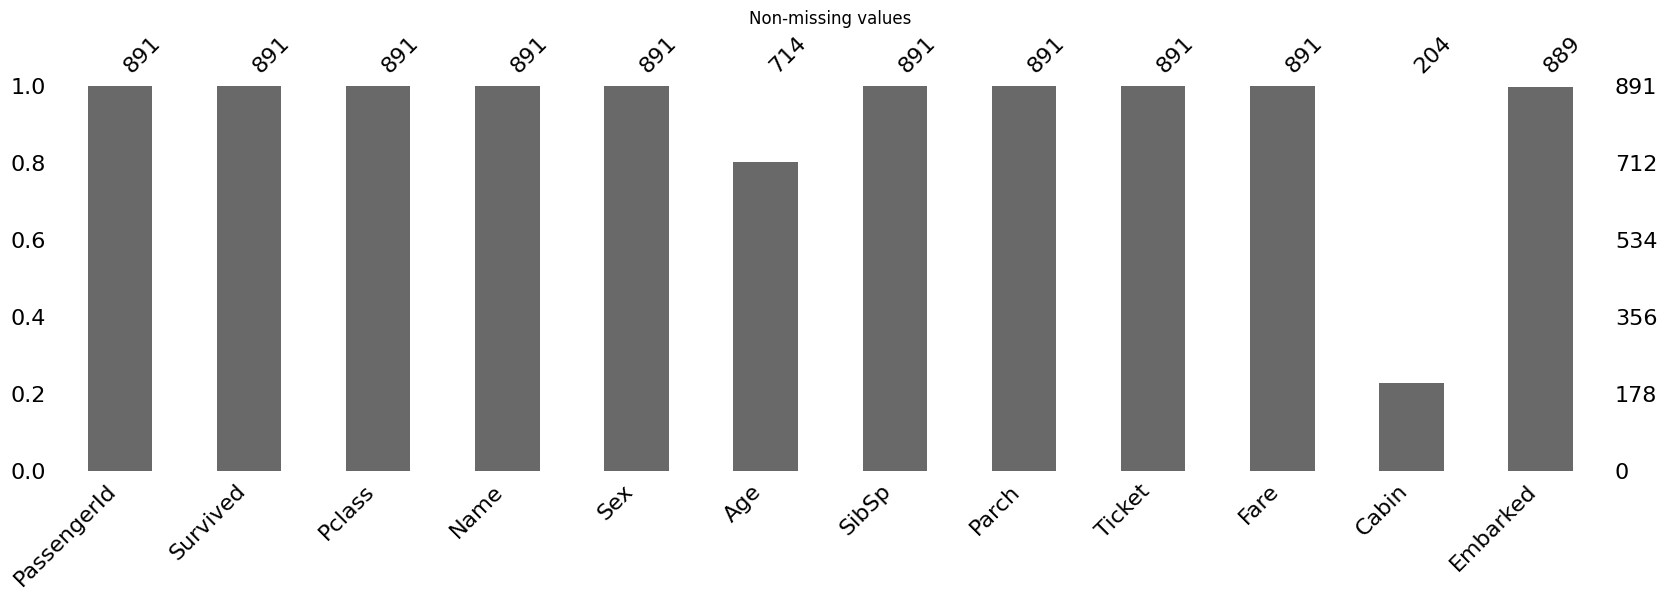

In [7]:
# Extract the data type of the columns
train_dataset_dtype = train_dataset.dtypes

# Calculate the number of null values for each column
train_dataset_nulls = train_dataset.isnull().sum()
# Calculate nulls %
train_dataset_nulls_p = round(train_dataset_nulls / len(train_dataset) * 100, 1)

# Calculate the unique values (cardinality) of the features
train_dataset_cardinality = train_dataset.nunique()
train_dataset_cardinality_p = round(train_dataset.nunique() / len(train_dataset) * 100, 1)

# Build the DataFrame
train_dataset_info = pd.DataFrame({'Data Type': train_dataset_dtype,
                                   'Nulls': train_dataset_nulls,
                                   'Nulls %': train_dataset_nulls_p,
                                   'Cardinality': train_dataset_cardinality,
                                   'Cardinality %': train_dataset_cardinality_p}
                                 ).reset_index().rename(columns = {'index': "Feature"})
display(train_dataset_info)

msno.bar(train_dataset, figsize = (20, 5))
plt.title("Non-missing values")
plt.show()

Based on the train_dataset_info dataframe, "Age", "Cabin", and "Embarked" are the only columns in the training set with missing values, with "Cabin" having the highest proportion (77%). We can also identify columns with high cardinality (many unique values). In the next steps, we will process these columns to address both missing values and high cardinality.

### Statistics metrics

In [8]:
# Describe the train_dataset
train_dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Function to extract numerical columns and calculate the skew
def col_skew(df):
    df_numeric_cols = df.select_dtypes(include = ['int64', 'float64']).columns
    df_numeric_cols_skew = df[df_numeric_cols].skew()
    return df_numeric_cols_skew

# Extract numerical columns and calculate the skew for the unprocessed train dataset
col_skew(train_dataset)

PassengerId    0.000000
Survived       0.478523
Pclass        -0.630548
Age            0.389108
SibSp          3.695352
Parch          2.749117
Fare           4.787317
dtype: float64

Based on the col_skew() function, we decide whether to use the mean or the median to impute missing values. If the skewness of a column is ≤ 0.5, we use the mean, since it performs better when the data is not highly skewed, otherwise, we use the median.

In [10]:
# Extract categorical columns
train_cat_cols = train_dataset.select_dtypes(include = 'object')

# Drop 100% cardinality columns
high_card_cols = train_dataset_info[train_dataset_info['Cardinality %'] == 100]['Feature'].tolist()
cols_to_drop = [col for col in high_card_cols if col in train_cat_cols.columns]
train_cat_cols = train_cat_cols.drop(columns = cols_to_drop)
train_cat_cols.columns

Index(['Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

# Handling Missing Values (manually)

In this section, we will create functions to impute the missing values.

## Numerical columns

In [11]:
train_dataset_processed = train_dataset.copy()

# Extract numerical columns and calculate the skew
col_skew(train_dataset_processed)

# Function to replace missing values for numerical columns
def num_fill_nan(df):
    # Extract the columns that contain missing values
    df_numeric = df.select_dtypes(include = ['int64', 'float64'])
    df_nan_col = df_numeric.columns[df_numeric.isnull().any()].tolist()
    # Iterate through all the columns with missing values and fill them with mean if the absolute skew value <= 0.5, otherwise, with the median.
    for col in df_nan_col:
        skew_val = col_skew(df)[col]
        if abs(skew_val) <= 0.5:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].median())
    return df 
train_dataset_processed = num_fill_nan(train_dataset_processed)

# Create the "Age_was_nan" boolean column to identify what were the nan values which was filled in using the num_fill_nan function
train_dataset_processed["Age_was_nan"] = train_dataset["Age"].isnull().astype(int)

The numerical columns with missing values will be imputed using either the mean or the median. Additionally, we will create an extra column "Age_was_nan" to indicate which samples originally had missing values. This way, the model can treat them separately and take into account that the values for these samples were not part of the original data but were imputed through an artificial process.

## Categorical columns

In [12]:
# Function to replace missing values for categorical columns with "Missing"
def cat_fill_nan(df):
    df_categorical = df.select_dtypes(include = ['object'])
    df_nan_col = df_categorical.columns[df_categorical.isnull().any()].tolist()
    for col in df_nan_col:
        df[col] = df[col].fillna("Missing")
    return df

cat_fill_nan(train_dataset_processed)

# Create "Cabin_Letter" column to extract the first letter of the Cabin
train_dataset_processed['Cabin'] = train_dataset_processed['Cabin'].str[0]

Missing values in categorical columns are replaced with "Missing", and the "Cabin" column's cardinality is reduced by keeping only its first letter.

# Distribution and Visualization

## Numerical columns

### Plot "Age" column before and after

In [13]:
# Function to create a histogram before/after for numerical columns
def num_col_hist_before_after(col_before, col_after):    
    plt.figure(figsize = (12, 4))
    
    # Distribution before
    plt.subplot(1, 2, 1)
    sns.histplot(col_before, kde = 'True', color = 'red')
    plt.title(f'{col_before.name} with NaN')

    # Distribution after
    plt.subplot(1, 2, 2)
    sns.histplot(col_after, kde = 'True', color = 'green')
    plt.title(f'{col_after.name} without NaN')

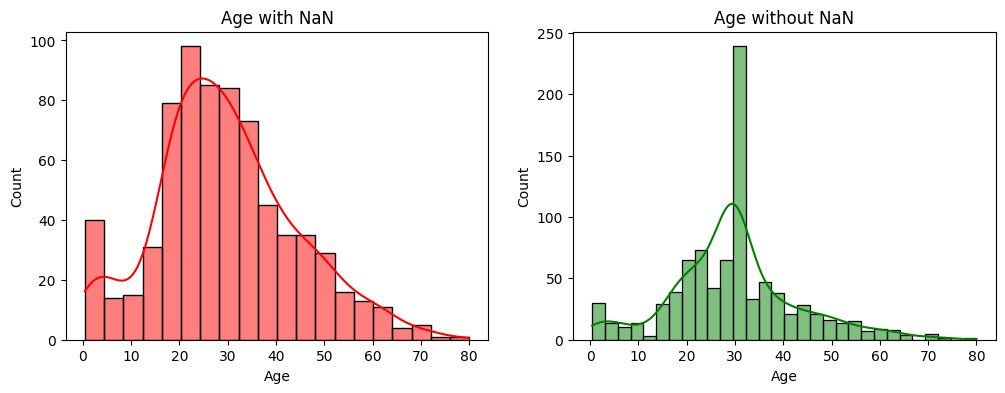

In [14]:
# Plot the "Age" column before and after filling the missing values
num_col_hist_before_after(train_dataset['Age'], train_dataset_processed['Age'])

Plotting the "Age" column before and after imputation, we can see how the distribution originally looked. With a skewness of ≈ 0.39, the data is right-skewed. After filling in the missing values with the mean, the imputed values are represented by the mean, and the distribution becomes more normal.

### Plot "Pclass" columns

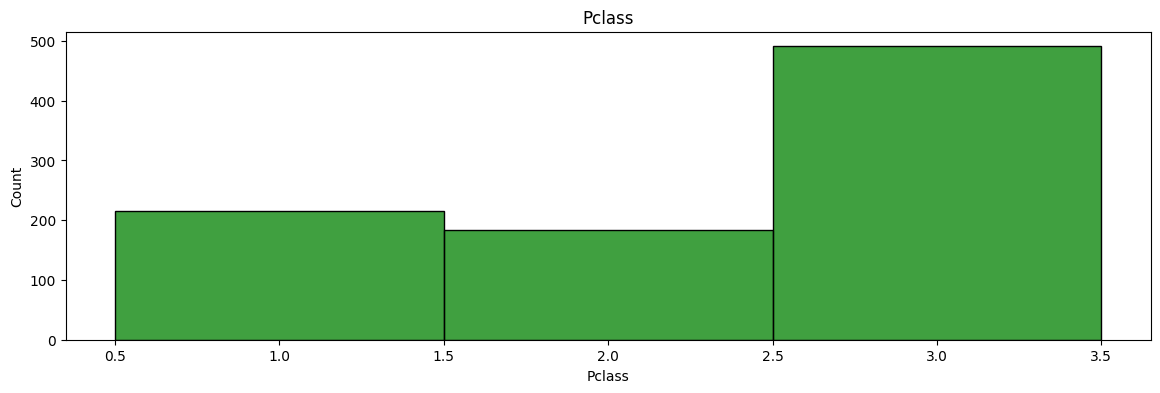

In [15]:
# Function to plot the numerical columns
def hist_plot(feature, kde = False, discrete = False, bins = 'auto', color = 'green'):
    plt.figure(figsize = (14,4))

    plt.subplot(1, 1, 1)
    sns.histplot(feature, kde = kde, discrete = discrete, bins = bins, color = color)
    plt.title(f'{feature.name}')

hist_plot(train_dataset_processed['Pclass'], discrete = True)

Based on the Pclass histogram, we can see that most passengers were in Pclass 3. No transformation is needed for this feature, but one-hot encoding may be considered for linear models such as Logistic Regression, while tree-based models like Random Forest or XGBoost can use the numeric values directly.

### Plot "Fare" column

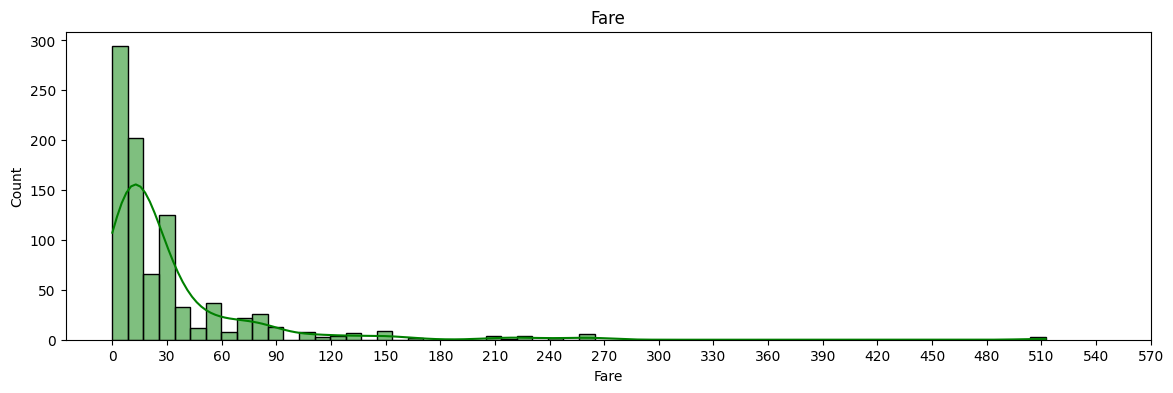

In [16]:
hist_plot(train_dataset_processed['Fare'], kde = True)
plt.xticks(range(0, 600, 30)) # _ is a dummy variable and matplotlib will not print all the tickers in the output
plt.show()

Based on the Fare histogram, we can see that most passengers had a fare between 0 and 30, while the remaining values are relatively uncommon. Applying transformations such as standardization or logarithmic scaling may help improve the performance of linear models like Logistic Regression, while tree-based models such as Random Forest or XGBoost generally do not require such preprocessing.

## Categorical columns

In [17]:
# Function to create a countplot before/after for categorical columns
def cat_col_countplot_before_after(col_before, col_after, top_n = 15):
    plt.figure(figsize = (14, 4))

    # Distribution before
    top_values_before = col_before.value_counts().nlargest(top_n)
    col_grouped_before = col_before.apply(lambda x: x if x in top_values_before else "Other")

    plt.subplot(1, 2, 1)
    sns.countplot(y = col_grouped_before, order = list(top_values_before.index) + ['Other'], color = 'red')
    plt.title(f'{col_before.name} with NaN')

    # Distribution after
    top_values_after = col_after.value_counts().nlargest(top_n)
    col_grouped_after = col_after.apply(lambda x: x if x in top_values_after else "Other")

    plt.subplot(1, 2, 2)
    sns.countplot(y = col_grouped_after, order = list(top_values_after.index) + ['Other'], color = 'green')
    plt.title(f'{col_after.name} without NaN')

### Plot "Cabin" column before and after

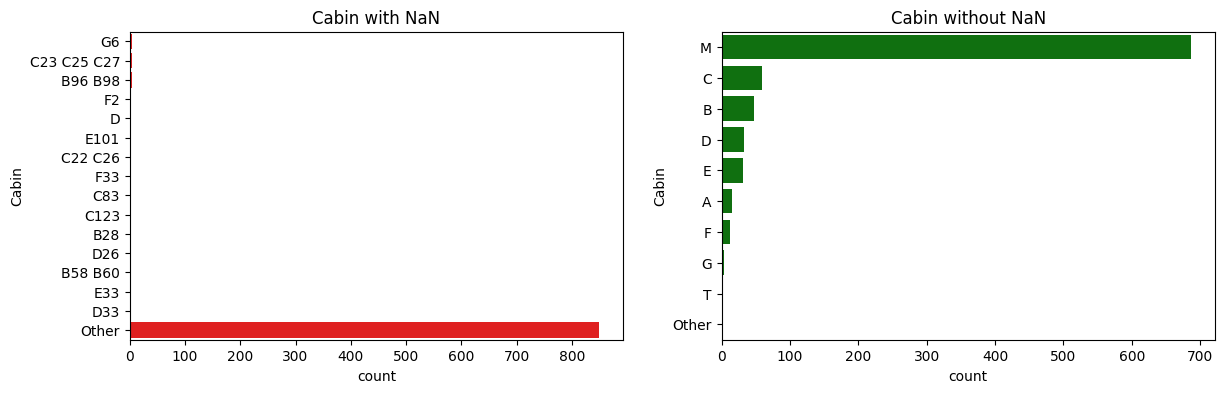

In [18]:
# Plot the "Cabin" before and after filling the missing values
cat_col_countplot_before_after(train_dataset['Cabin'], train_dataset_processed['Cabin'])

Plotting the "Cabin" column before and after imputation, we can see that the values are clearer and easier to interpret after keeping only the first letter of each entry. The letter "M" represents missing values.

### Plot "Embarked" column before and after

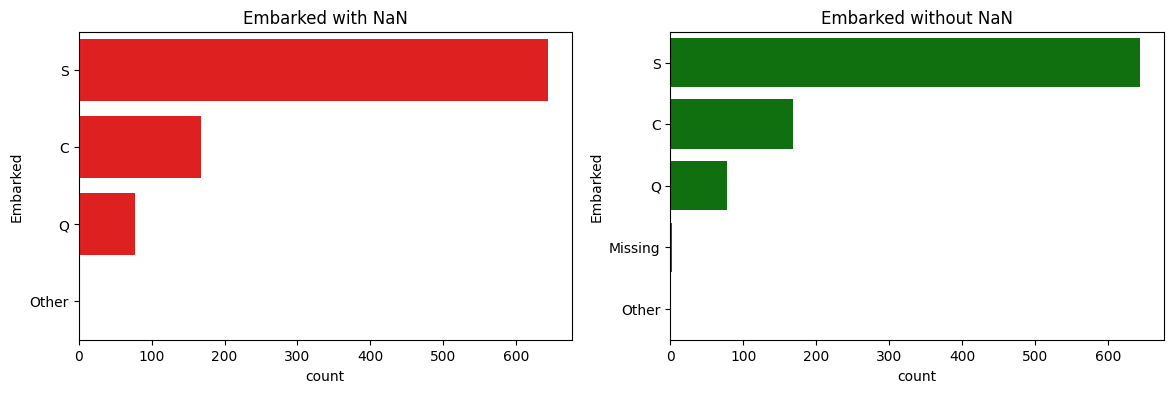

In [19]:
# Plot the "Embarked" before and after filling the missing values
cat_col_countplot_before_after(train_dataset['Embarked'], train_dataset_processed['Embarked'])

The "Embarked" column remains almost unchanged after filling missing values, as there were only two missing entries, visible in the "Embarked without NaN" visualization.

### Plot "Sex" column

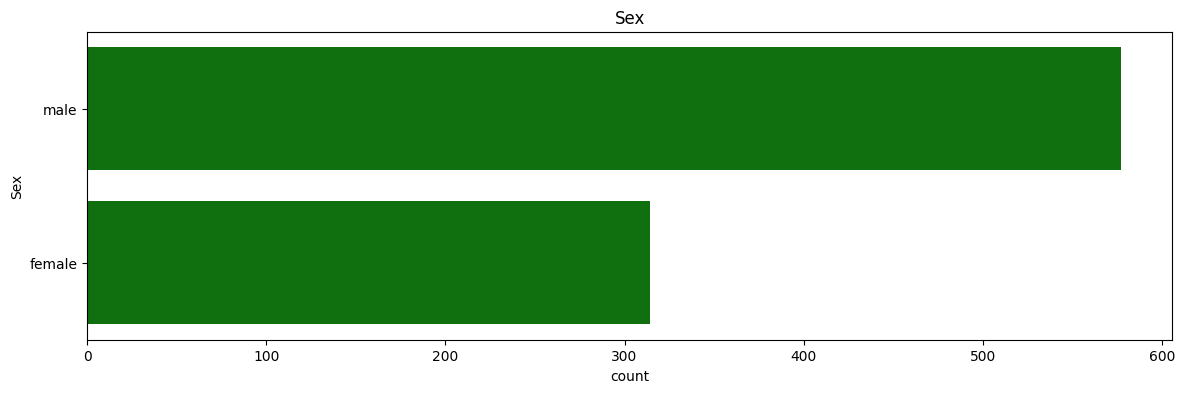

In [20]:
# Function to plot categorical columns
def cat_col_countplot(feature, color = 'green'):
    plt.figure(figsize = (14, 4))

    plt.subplot(1, 1, 1)
    sns.countplot(y = feature, color = color, order = feature.value_counts().index)
    plt.title(f'{feature.name}')

# Plot "Sex" column
cat_col_countplot(train_dataset_processed['Sex'])

Based on the Sex countplot visualization, the distribution between males and females is imbalanced, with males being almost twice as frequent as females. Since this is a categorical variable without an inherent order, it will need to be transformed using OneHotEncoding (or binary encoding, as it has only two categories) in order to be properly used by machine learning models.

Additionally, due to the imbalance between males and females, we may need to apply oversampling, undersampling, or weighted loss methods. The choice will be guided by the F1 score and other relevant performance metrics.

### Plot "Ticket" column

Since the "Ticket" column has high cardinality, we will create a function to process it by extracting meaningful patterns and handling missing or purely numeric values. This will reduce the number of unique categories and make the feature suitable for machine learning models.

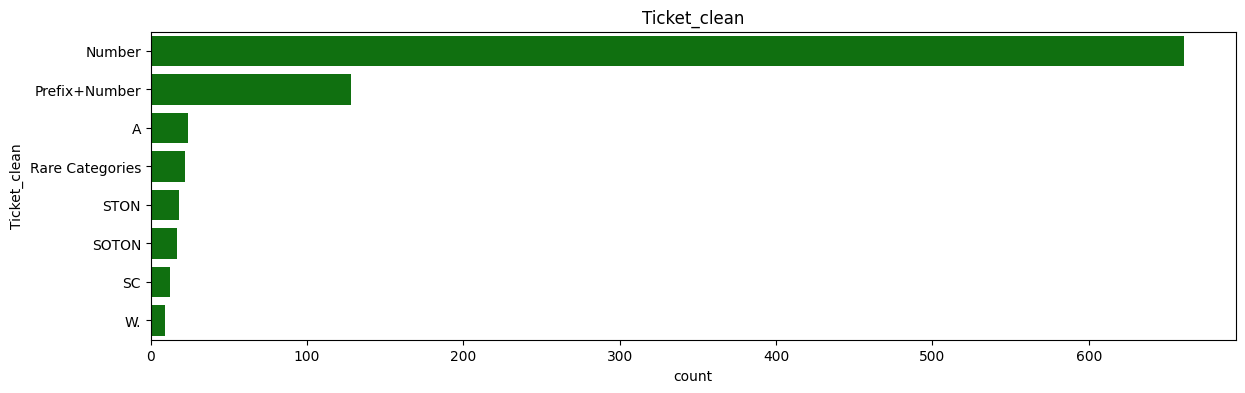

In [21]:
# Function to clean the "Ticket" column
def process_ticket(ticket):
    if pd.isna(ticket):
        return 'Missing'
    if '/' in ticket:
        return ticket.split('/')[0].strip()
    if ' ' in ticket:
        return 'Prefix+Number'
    if ticket.isdigit():
        return 'Number'
    else:
        return 'Other'
    
# Apply the function to create the "Ticken_clean column"
train_dataset_processed['Ticket_clean'] = train_dataset_processed['Ticket'].apply(process_ticket)

# Get rare values
counts = train_dataset_processed['Ticket_clean'].value_counts()
rare_categories = counts[counts <=5].index.tolist()

# Group rare categories inside 'Rare Categories'
train_dataset_processed['Ticket_clean'] = train_dataset_processed['Ticket_clean'].apply(
    lambda x: 'Rare Categories' if x in rare_categories
    else x
)

# Plot "Ticket" column
cat_col_countplot(train_dataset_processed['Ticket_clean'])

After creating the "Ticket_clean" column, grouping rare categories, and plotting it, we can see that the cardinality has been significantly reduced. However, the categories remain imbalanced, so we will apply OneHotEncoding to prepare the data for the models.

# Correlation and Relationship

The objective of this section is to identify relevant features to include in the model and exclude redundant ones. To achieve this, we will use multiple visualizations and analyses, including:

- Heatmaps to examine correlations with the target and collinearity between numerical features;
- Crosstab heatmaps to visualize interactions between categorical features;
- Scatter plots to explore relationships between numerical features, overall distribution, and potential non-linear patterns;
- Boxplots to visualize the mean, median, quartiles, and outliers;
- FacetGrid, crosstabs and heatmaps for multivariate relationships
- Missingno plots to confirm that no missing values remain.

## Heatmaps
We create heatmaps to visualize the Pearson correlation matrix of numerical features.

<Axes: >

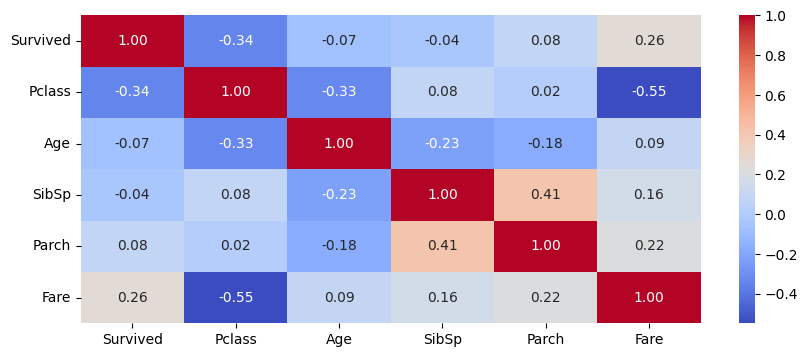

In [22]:
# Extract the numerical columns after processing the train dataset
train_dataset_processed_num_cols = train_dataset.select_dtypes(include = ['int64', 'float64']).columns

# Exclude PassengerID since it contains unique values and it's irrelevant
train_dataset_processed_num_cols = train_dataset_processed_num_cols.drop('PassengerId')

# Plot the columns using heatmap
plt.figure(figsize = (10, 4))
train_num_cols_corr = train_dataset_processed[train_dataset_processed_num_cols].corr()
sns.heatmap(train_num_cols_corr, annot = True, cmap = 'coolwarm', fmt = '.2f')

The generated heatmap shows negative correlations in blue and positive correlations in red.

To remove strongly correlated redundant features, we check whether the absolute correlation between features is ≥ 0.8. The default threshold in the function below is 0.8, but it can be adjusted if needed. In this dataset, no features meet this criterion, so no redundant features are removed.

Next, we remove features with low correlation to the target. Based on the heatmap, "Age", "SibSp", and "Parch" have correlations below 0.1 and will be dropped by the drop_redundant_features function.

After this step, the only remaining features are "Pclass" and "Fare". These features are quite correlated, but we will keep both for now.

In [23]:
# Function to automatically drop redundant features
def drop_redundant_features(df, df_num_cols, target_col = 'Survived', ff_threshold = 0.8, ft_threshold = 0.1):
    # Calculate features vs feature correlation
    train_corr_cols = df_num_cols.drop(target_col)
    train_ff_corr = df[train_corr_cols].corr().abs()
    print('Feature vs feature Pearson correlation matrix:')
    display(train_ff_corr)
    
    # Calculate features vs target correlation
    train_ft_corr = df[train_corr_cols].corrwith(df["Survived"]).abs().to_frame(name = 'Survived')
    print('Feature vs target Pearson correlation matrix:')
    display(train_ft_corr.sort_values(by = target_col, ascending = False))
    
    # Drop redundant columns based on Pearson Correlation
    train_num_features_cols = set(train_corr_cols)
    train_num_features_cols_discarded = set() 
    # Calculate the feature vs feature corr to remove colinearity (feature vs feature corr >= ff_threshold)
    for i in range(len(train_corr_cols)):
        for j in range(i + 1, len(train_corr_cols)): # i + 1 will exclude the duplicated correlations and the diagonal correlation (Age vs Age)
            f_i = train_corr_cols[i]
            f_j = train_corr_cols[j]
            if train_ff_corr.loc[f_i, f_j] >= ff_threshold:
                if train_ft_corr.loc[f_i, 'Survived'] >= train_ft_corr.loc[f_j, 'Survived']:
                    train_num_features_cols.discard(f_j)
                    train_num_features_cols_discarded.add(f_j)
                else:
                    train_num_features_cols.discard(f_i)
                    train_num_features_cols_discarded.add(f_i)
    
    # Remove redundant features vs target (feature vs target corr < ft_threshold)
    for f in list(train_num_features_cols):
        if train_ft_corr.loc[f, 'Survived'] < ft_threshold:
            train_num_features_cols.discard(f)
            train_num_features_cols_discarded.add(f)
            
    # Print discarded columns and the correlation with the target
    print(f'\n❌ Discarded features: {sorted(train_num_features_cols_discarded)}')
    for f in list(train_num_features_cols_discarded):
        print(f'- Weak correlation of feature {f} with the target: {train_ft_corr.loc[f, target_col]:.2f}')

    # Print kept columns and the correlation with the target
    print(f'\n✅ Kept features to be included in the model: {sorted(train_num_features_cols)}')
    for f in train_num_features_cols:
        print (f'- Feature "{f}" corelation with the target: {train_ft_corr.loc[f, target_col]:.2f}') 
    return train_num_features_cols

drop_redundant_features(train_dataset_processed, train_dataset_processed_num_cols)

Feature vs feature Pearson correlation matrix:


,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,0.331339,0.083081,0.018443,0.549500
Age,0.331339,1.000000,0.232625,0.179191,0.091566
SibSp,0.083081,0.232625,1.000000,0.414838,0.159651
Parch,0.018443,0.179191,0.414838,1.000000,0.216225
Fare,0.549500,0.091566,0.159651,0.216225,1.000000


Feature vs target Pearson correlation matrix:


,Survived
Pclass,0.338481
Fare,0.257307
Parch,0.081629
Age,0.069809
SibSp,0.035322



❌ Discarded features: ['Age', 'Parch', 'SibSp']
- Weak correlation of feature SibSp with the target: 0.04
- Weak correlation of feature Parch with the target: 0.08
- Weak correlation of feature Age with the target: 0.07

✅ Kept features to be included in the model: ['Fare', 'Pclass']
- Feature "Fare" corelation with the target: 0.26
- Feature "Pclass" corelation with the target: 0.34


{'Fare', 'Pclass'}

## Crosstab, Heatmaps and Chi-Square

We create crosstabs and heatmaps to visualize the relationships between categorical features and the target variable. We then compute the Chi-Square test to determine whether the features are independent of the target "Survived". The Chi-Square test serves as a second layer to identify reliable columns to be included in the model.

In [24]:
# Create function for crosstab and heatmap
def crosstab_heatmap_chi2(df, feature, target = 'Survived', cmap = 'YlGnBu', figsize = (20, 4)):
    # Absolute values crosstab
    ct = pd.crosstab(df[feature], df[target], normalize = False, margins = True)
    display(ct)

    # Percents crosstab
    ct_p = pd.crosstab(df[feature], df[target], normalize = True, margins = True)
    display(ct_p)

    # Create the heatmaps
    fig, axes = plt.subplots(1, 2, figsize = figsize)
    sns.heatmap(ct, annot = True, fmt = 'd', cmap = cmap, ax = axes[0]).set_title(f'{feature} absolute value')
    sns.heatmap(ct_p, annot = True, fmt = '.2f', cmap = cmap, ax = axes[1]).set_title(f'{feature} percent %')

    # Compute Chi-Square and p-value
    ct = pd.crosstab(df[feature], df[target], normalize = False, margins = False)
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f'{feature} vs {target}: p-value = {p:4f}')

### Crosstab and heatmap "Sex" with "Survived"

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


Survived,0,1,All
Sex,,,
female,0.090909,0.261504,0.352413
male,0.525253,0.122334,0.647587
All,0.616162,0.383838,1.000000


Sex vs Survived: p-value = 0.000000


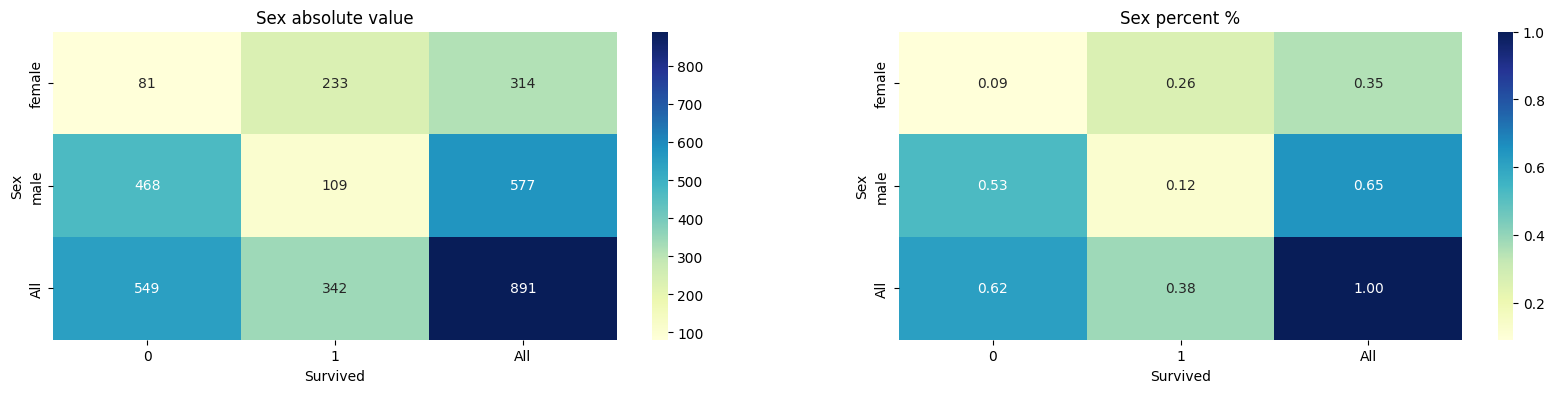

In [25]:
crosstab_heatmap_chi2(train_dataset_processed, 'Sex')

Based on the crosstab matrix and heatmap visualization, we can identify a strong relationship between the feature "Sex" and the target "Survived". Overall, ~62% of passengers did not survive, most of them being male (~53% of all passengers). Among females, 233 out of 314 (~74%) survived, whereas only 109 out of 577 (~19%) males survived. This indicates that "Sex" is an important predictor: males had a higher probability of not surviving, while females had a much higher probability of survival.

The p-value is 0.000, being lower than 0.05, confirming that the "Sex" feature is significantly associated with the "Survived" target.

### Crosstab and heatmap "Ticket_clean" with "Survived"

Survived,0,1,All
Ticket_clean,,,
A,22,2,24
Number,407,254,661
Prefix+Number,66,62,128
Rare Categories,15,7,22
SC,6,6,12
SOTON,15,2,17
STON,10,8,18
W.,8,1,9
All,549,342,891


Survived,0,1,All
Ticket_clean,,,
A,0.024691,0.002245,0.026936
Number,0.456790,0.285073,0.741863
Prefix+Number,0.074074,0.069585,0.143659
Rare Categories,0.016835,0.007856,0.024691
SC,0.006734,0.006734,0.013468
SOTON,0.016835,0.002245,0.019080
STON,0.011223,0.008979,0.020202
W.,0.008979,0.001122,0.010101
All,0.616162,0.383838,1.000000


Ticket_clean vs Survived: p-value = 0.001175


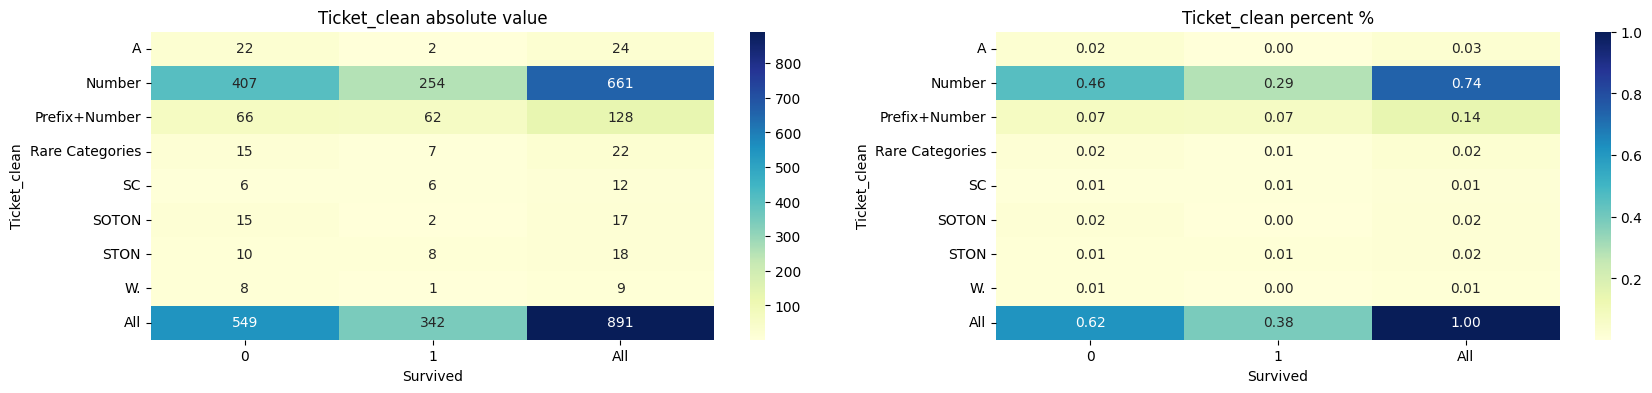

In [26]:
crosstab_heatmap_chi2(train_dataset_processed, 'Ticket_clean')

Based on the crosstab and heatmap, we can observe a weak association between the "Ticket_clean" feature and the target "Survived". Most passengers fall into the "Number" or "Prefix+Number" categories, which explains why the survival distribution largely reflects the overall proportions. The other categories have very few passengers and contribute minimally. Therefore, the "Ticket_clean" column has little predictive power and will not be included in the model.

The p-value is 0.09, which is greater than 0.05, confirming that the "Ticket_clean" feature is independent of the "Survived" target.

### Crosstab and heatmap "Cabin" with "Survived"

Survived,0,1,All
Cabin,,,
A,8,7,15
B,12,35,47
C,24,35,59
D,8,25,33
E,8,24,32
F,5,8,13
G,2,2,4
M,481,206,687
T,1,0,1


Survived,0,1,All
Cabin,,,
A,0.008979,0.007856,0.016835
B,0.013468,0.039282,0.052750
C,0.026936,0.039282,0.066218
D,0.008979,0.028058,0.037037
E,0.008979,0.026936,0.035915
F,0.005612,0.008979,0.014590
G,0.002245,0.002245,0.004489
M,0.539843,0.231201,0.771044
T,0.001122,0.000000,0.001122


Cabin vs Survived: p-value = 0.000000


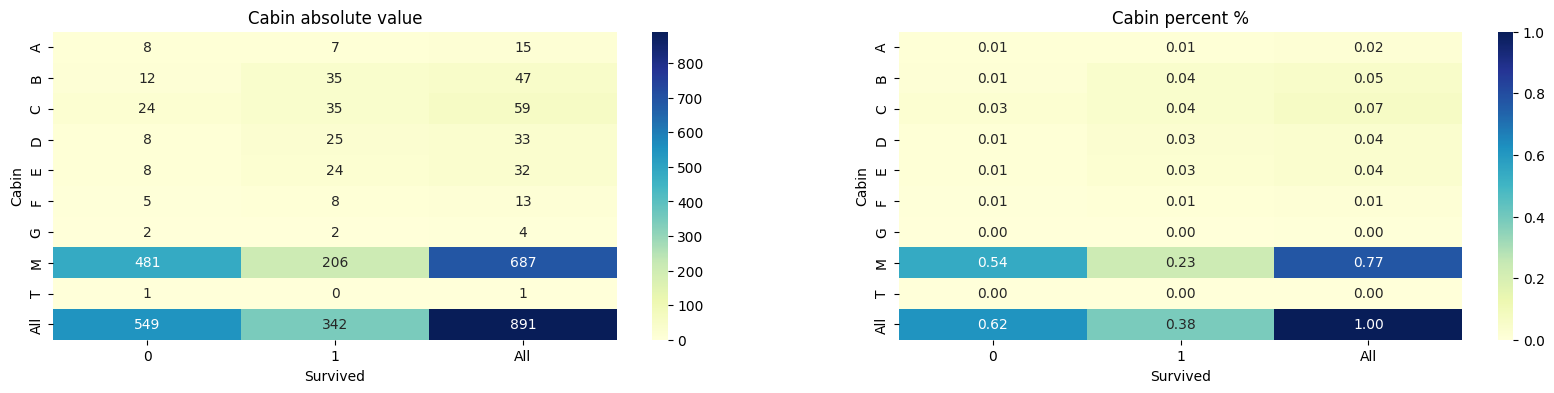

In [27]:
crosstab_heatmap_chi2(train_dataset_processed, 'Cabin')

Similarly to "Ticket_clean", the "Cabin" feature shows a weak association with the target "Survived". The majority of passengers (≈77%) have missing cabin information, and the remaining categories contain very few passengers each.

The p-value is 0.00, which is lower than 0.05, suggesting that the "Cabin" feature is statistically associated with the "Survived" target. However, since most of the data is missing, the "Cabin" column provides little predictive power and will be excluded from the models.

### Crosstab and heatmap "Embarked" with "Survived"

Survived,0,1,All
Embarked,,,
C,75,93,168
Missing,0,2,2
Q,47,30,77
S,427,217,644
All,549,342,891


Survived,0,1,All
Embarked,,,
C,0.084175,0.104377,0.188552
Missing,0.000000,0.002245,0.002245
Q,0.052750,0.033670,0.086420
S,0.479237,0.243547,0.722783
All,0.616162,0.383838,1.000000


Embarked vs Survived: p-value = 0.000002


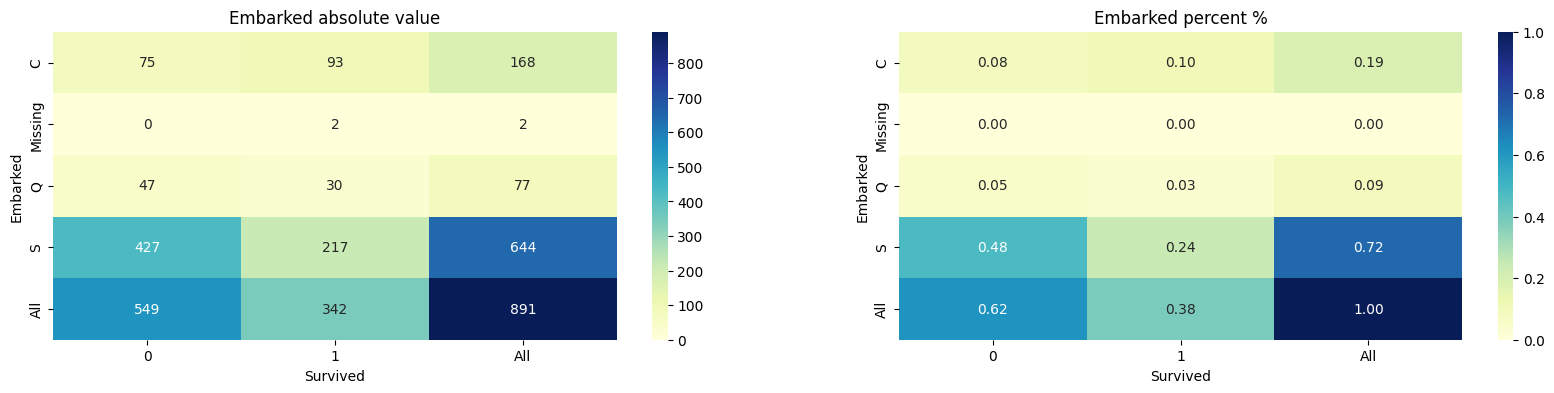

In [28]:
crosstab_heatmap_chi2(train_dataset_processed, 'Embarked')

The same observation applies to the "Embarked" column, as most passengers embarked from port "S" (~72%), giving this category more weight in the model. However, differences between ports are noticeable: ~55% of passengers from port "C" survived, compared to only ~37% from port "S".

The p-value is 0.0002, suggesting that the "Embarked" feature may be associated with the "Survived" target. Even though the column is skewed, this feature may still be useful, so we will keep it for further testing and investigation. If included in the model, OneHotEncoder should be applied to this feature.

Based on the above analyses, we conclude to keep only the "Sex" and "Embarked" columns among categorical features, and to exclude "Cabin" and "Ticket_clean".

## Scatter plot for numerical columns

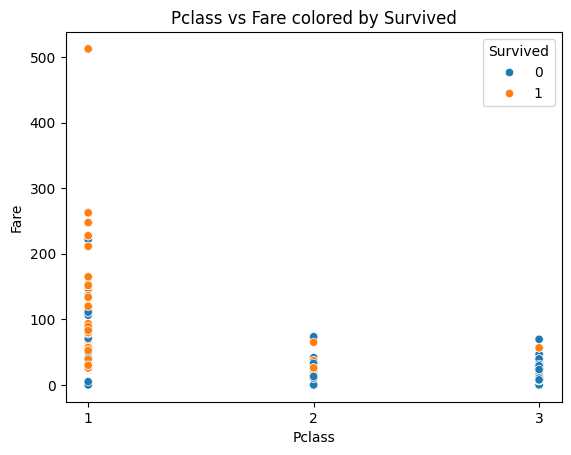

In [29]:
# Scatter plot for "Pclass" vs "Fare" colored by "Survived" target
sns.scatterplot(
    x = 'Pclass',
    y = 'Fare',
    hue = 'Survived',
    data = train_dataset_processed
)
plt.title("Pclass vs Fare colored by Survived")
plt.xticks([1, 2, 3])
plt.show()

Based on the scatterplot visualisation between "Pclass" and "Fare", "Pclass" 1 appears to include more survivors compared to "Pclass" 3. In "Pclass" 2, there is no dominant survival category, as the chances of survival are roughly 50-50%. There is an inverse relationship between "Fare" and "Pclass", since "Fare" tends to increase as "Pclass" decreases (premium class), with an outlier among the survivors.

In conclusion, there is a strong relationship between the features "Fare" and "Pclass" and the target "Survived", indicating that passengers in "Pclass" 1 who paid higher fares had higher chances of survival.

As a next step, the "Fare" column will be log-transformed to prevent the outliers from disproportionately affecting other features.

## Boxplot for numerical columns

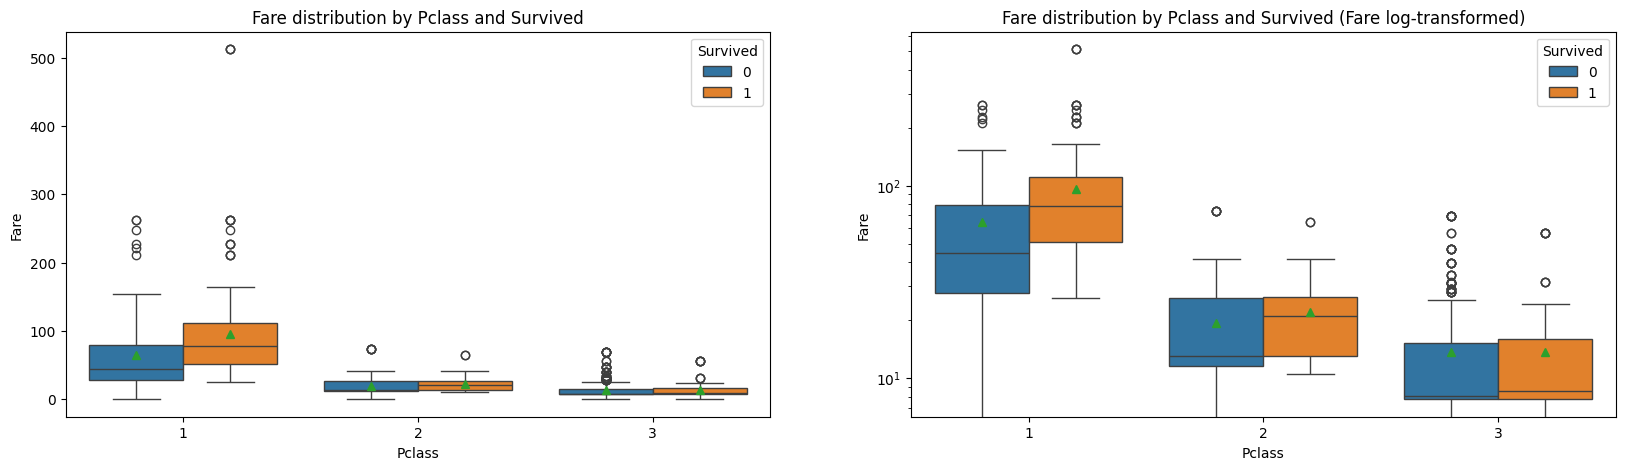

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
sns.boxplot(train_dataset_processed, x = 'Pclass', y = 'Fare', hue = 'Survived', ax = axes[0], showmeans = True)
sns.boxplot(train_dataset_processed, x = 'Pclass', y = 'Fare', hue = 'Survived', ax = axes[1], showmeans = True)
axes[0].set_title("Fare distribution by Pclass and Survived")
axes[1].set_title("Fare distribution by Pclass and Survived (Fare log-transformed)")
axes[1].set_yscale('log') # Reduces the outliers impact


Based on the boxplot above, we can see that survival chances increased with higher fares for passengers in Pclass 1, with 50% of the survivors paying a fare between 50 and 100. For Pclass 3, even though there are outliers showing some passengers paid significantly more than the majority, these higher fares did not seem to increase their survival probability. Additionally, the presence of outliers in all three Pclasses is evident from the fact that the mean is consistently higher than the median, suggesting that a log-transformation should be applied to the Fare column.

We can also see that for all three classes, 75% of passengers paid roughly the same amount, yet some survived and some did not. This indicates that "Pclass" and "Fare" alone are not sufficient to predict a passenger's outcome, and additional features should be included to improve the model.

## Multivariate relationships and their effect on "Survived"

### FacetGrid between "Fare" and "Survived" by "Embarked" colored by "Sex"

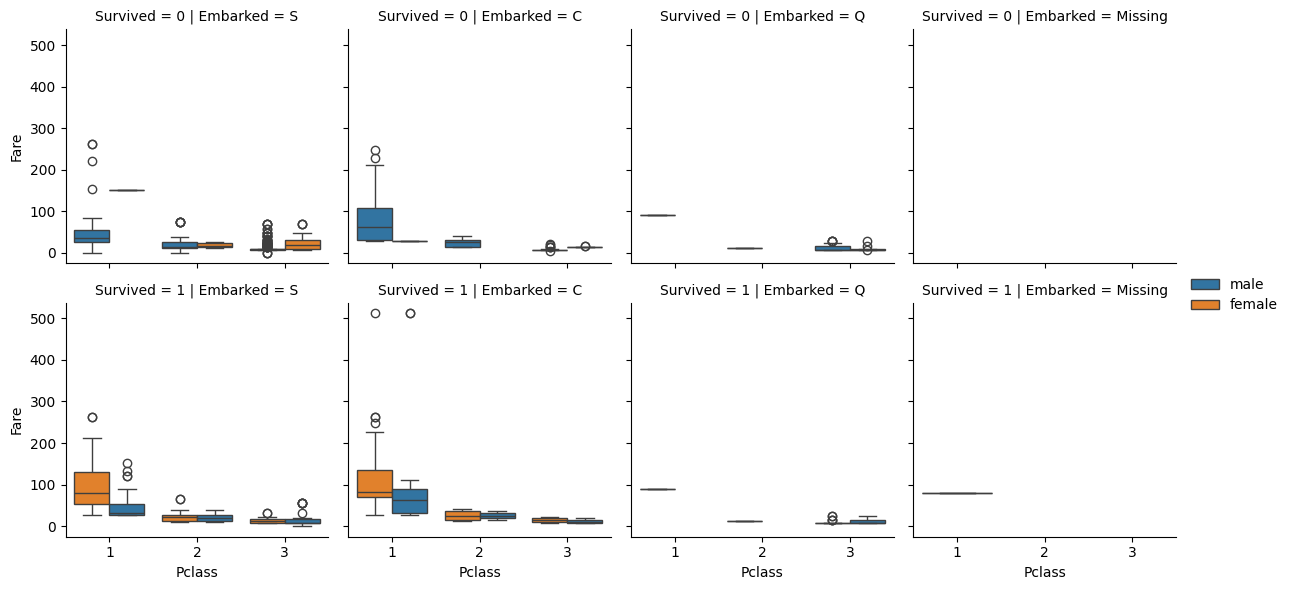

In [31]:
g = sns.FacetGrid(train_dataset_processed, col = 'Embarked', row = 'Survived')
palette = {'male': '#1f77b4', 'female': '#ff7f0e'}
g.map_dataframe(sns.boxplot, 'Pclass', 'Fare', hue = 'Sex', palette = palette)
g.add_legend()

Based on the FacetGrid visualization, several patterns can be highlighted:
- Port Q and Missing: no major differences were observed, therefore the focus is on ports C and S.
- Male passengers (Pclass 1, not survived): those who embarked from port C paid considerably higher fares (median ~200) compared to those from port S (median ~100).
- Survivors vs. non-survivors (males, port C, Pclass 1): non-survivors show higher fares than survivors, suggesting that fare alone is not a sufficient predictor of survival.
- Female passengers: fare distributions are generally more stable across ports, with fewer discrepancies compared to males. An exception is observed in port S, where non-surviving females paid higher fares compared to their male counterparts.
- Outliers: more extreme values appear among passengers from port S, especially males in Pclass 3 who did not survive.
- Data gaps: there are no non-surviving female passengers from port C in Pclass 2. For Pclass 1 and 3, fares are more concentrated around the median for non-survivors.

Overall, the visualization confirms that fare and survival patterns interact strongly with port of embarkation and passenger class, with larger variability observed for males compared to females.

Practical implications for modeling:
These observations suggest that Fare is a relevant predictor, but its effect on survival is not linear and depends strongly on interactions with Pclass, Embarked, and Sex. Outliers and skewness indicate that transformations (e.g., log-scaling or binning) may improve stability. The presence of rare subgroups highlights potential risks of overfitting, meaning that robust models (e.g., tree-based methods) may capture these interactions better than simple linear models.

### Crosstab and Heatmap between "Pclass", "Sex" and "Survived"

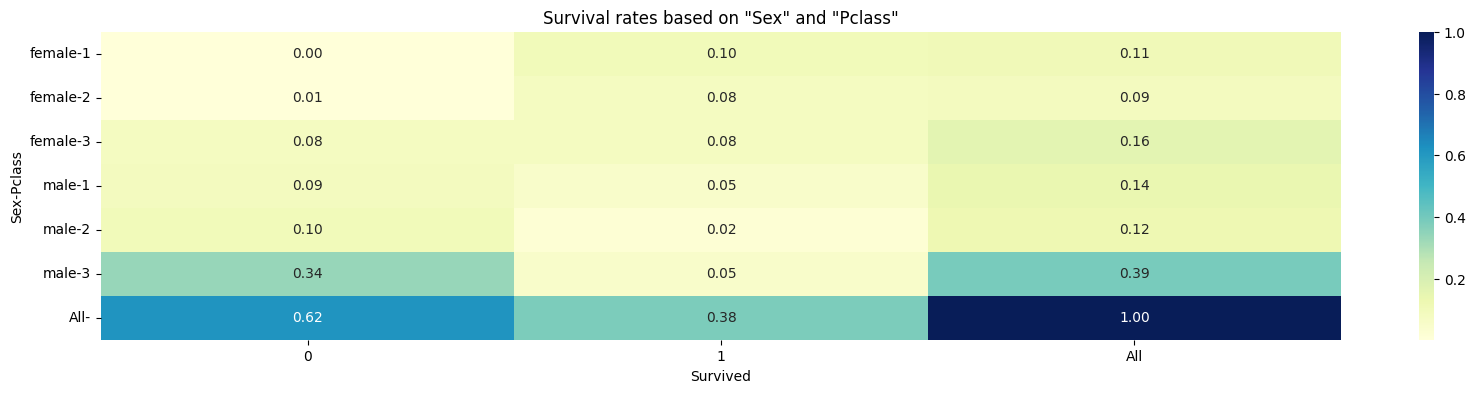

In [32]:
# Create crosstab
ct = pd.crosstab(
    index = [train_dataset_processed['Sex'], train_dataset_processed['Pclass']],
    columns = train_dataset_processed['Survived'],
    normalize = True,
    margins = True
)

# Create heatmap based on crosstab
plt.figure(figsize = (20, 4))
sns.heatmap(ct, annot = True, fmt = ".2f", cmap = "YlGnBu")
plt.title('Survival rates based on "Sex" and "Pclass"')
plt.show()

Based on the heatmap showing survival rates by Sex and Pclass, several patterns emerge:
- Out of the total 62% non-surviving passengers, approximately 53% were male, and around 34% belonged to Pclass 3, indicating a strong relationship between survival, sex, and class.
- For females, Pclass appears less predictive: only ~1% of Pclass 1 and 2 females did not survive, while for Pclass 3 the survival probability was roughly 50%.
- The imbalance between sexes is also notable: females represent only ~36% of passengers, with the remaining ~64% male. If needed, this imbalance can be addressed using oversampling, undersampling, or class-weighted loss, depending on the F1 score.

These observations suggest that Sex and Pclass are important predictors of survival, particularly for male passengers, while survival among females is less dependent on class.

## Misingno check

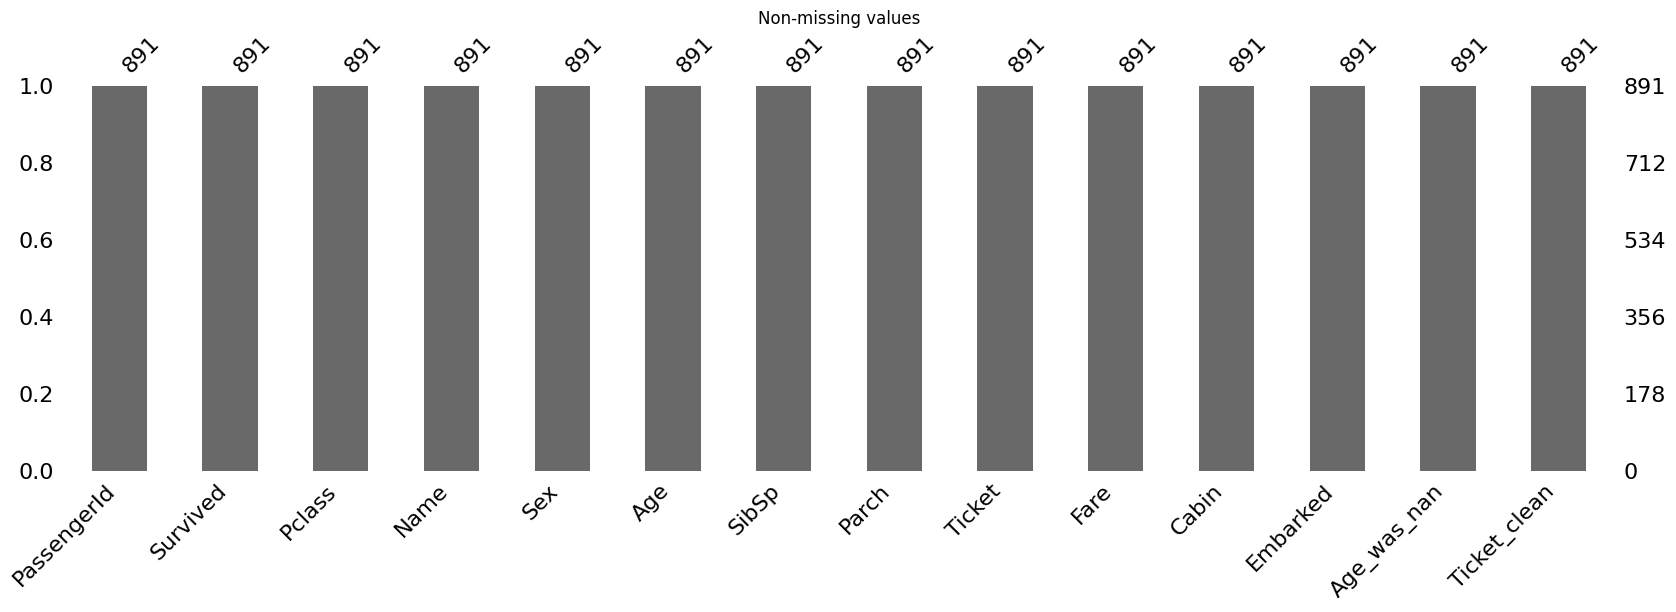

In [33]:
msno.bar(train_dataset_processed, figsize = (20, 5))
plt.title("Non-missing values")
plt.show()

Based on the Missingno bar plot, we can confirm that there are no remaining missing values in train_dataset_processed, allowing us to proceed to the next section.

# Feature Preparation

## Feature Engineering
Create new features from the existing dataset to capture hidden patterns and improve model performance.

## Feature Transformation
Apply mathematical transformations (e.g., log, binning, scaling) to reduce skewness and make features more suitable for modeling.

## Feature Encoding
Convert categorical features into numerical representations so they can be used effectively by machine learning models.

In [ ]:
# Select the categorical features
cat_features = ['Sex', 'Embarked']

# Initialize OneHotEncoder
ohe = OneHotEncoder(drop = 'first', sparse_output = False)

# Encode cat_features
cat_features_encoded = ohe.fit_transform(train_dataset_processed[cat_features])

# Extract cat_features names
cat_features_encoded_names = ohe.get_feature_names_out(cat_features)

# Build the categorical DataFrame
df_cat_features = pd.DataFrame(cat_features_encoded, columns = cat_features_encoded_names, index = train_dataset_processed.index)

# Concatenate the df_cat_features with the train_dataset_processed and drop the old categorical columns
train_dataset_processed_encoded = pd.concat(
    [train_dataset_processed.drop(cat_features, axis = 1), df_cat_features], axis = 1
)
train_dataset_processed_encoded.head()

# Extract the list of columns that should be included in the baseline model
numerical_features = ['Pclass', 'Fare']
encoded_features = ohe.get_feature_names_out(cat_features).tolist()
all_features = numerical_features + encoded_features

# Dump the all_features into a JSON to be used in 02_ML_Models
all_features_path = os.path.join(main_dir, 'data', 'processed', 'all_features.json')
with open(all_features_path, 'w') as f:
    json.dump(all_features, f)

# Export the train_dataset_processed into .csv and store it in the data/processed folder
processed_path_csv = os.path.join(main_dir, 'data', 'processed', 'train_dataset_processed_encoded.csv')
train_dataset_processed_encoded.to_csv(processed_path_csv, index = False)

# Next Steps

The next steps will be implemented in two additional notebooks:

1) **02_ML_Models** – The goal of this notebook is to train initial baseline models 
   (e.g., Logistic Regression, Random Forest) to establish reference performance.  
   Later, we will revisit this notebook after completing Chapter 7 (Feature Preparation) 
   to incorporate the engineered features and experiment with different feature combinations.  
   Only the best-performing model will be finalized here.

2) **03_Models_Evaluation** – This notebook will focus on evaluating the trained models 
   using multiple metrics such as Accuracy, Precision, Recall, and F1-score.  
   It will provide a clear comparison and highlight the model with the highest performance.
